In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to

In [3]:
validation_15x_uri= "SG10K-SV-Release-1.4-15x-validation.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(validation_15x_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    '_old_sv_id': str
    'qual': float64
    'filters': set<str>
    'callers_info': struct {
        manta: struct {
            ABHet: float64, 
            ABHom: float64, 
            ABHetMulti: array<float64>, 
            ABHomMulti: array<float64>, 
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            CR: int32, 
            END: int32, 
            HOMSEQ: array<str>, 
            INV3: bool, 
            INV5: bool, 
            LEFT_SVINSSEQ: array<str>, 
            LOGF: float64, 
            MaxAAS: array<int32>, 
            MaxAASR: array<float64>, 
            MaxAltPP: int32, 
            MQ: int32, 
            MQsquared: int32, 
            NCLUSTERS: int32, 
            NGT: array<i

In [5]:
# add metadata
release14_sample_metadata_uri = "2021_06_18_supplier_metadata.n10714_replacespace.txt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
### import metadata
t = hl.import_table(release14_sample_metadata_uri, delimiter="\t", quote="\"", impute=True)
#t.describe()

## annotate the hail mt with metadata
t = t.rename({"NPM_Research_ID" : "s"})
t = t.key_by(t.s)
mt = mt.annotate_cols(metadata = t[mt.s])
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [7]:
mt = hl.variant_qc(mt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df = mt.select_rows(
    svtype = mt.callers_info.SVTYPE,
    ac = mt.variant_qc.AC[1]
).rows().select('svtype', 'ac').to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype  ac
0        DEL   1
1        DUP  24
2        DUP   1
3        DUP  10
4        INS   2
...      ...  ..
40878    DUP   2
40879    DUP   1
40880    DUP   2
40881    DUP  58
40882    DUP   2

[40883 rows x 2 columns]

In [10]:
%%sh
pip install boto3

In [11]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


df = (mt
      #.filter_rows((hl.is_missing(mt.info.manta.PASS_GT2_filter)) | (mt.info.manta.PASS_GT2_filter=="PASS"), keep=True)
      .select_rows(svtype = mt.callers_info.SVTYPE, 
                   ac = mt.variant_qc.AC[1])
      .rows()
      .select('svtype', 'ac')
      .to_pandas()
     )

# Separate 'ac' values for DEL and DUP SV types
ac_del = df[df['svtype'] == 'DEL']['ac']
ac_dup = df[df['svtype'] == 'DUP']['ac']
ac_ins = df[df['svtype'] == 'INS']['ac']

# Calculate cumulative distributions for DEL and DUP SV types
ac_del_counts = ac_del.value_counts().sort_index()
ac_dup_counts = ac_dup.value_counts().sort_index()
ac_ins_counts = ac_ins.value_counts().sort_index()

cum_dist_del = ac_del_counts.cumsum() / ac_del_counts.sum()
cum_dist_dup = ac_dup_counts.cumsum() / ac_dup_counts.sum()
cum_dist_ins = ac_ins_counts.cumsum() / ac_ins_counts.sum()


# Plot cumulative distribution of allele counts (ac)
plt.figure(figsize=(8, 6))
plt.plot(cum_dist_del.index, cum_dist_del.values, label='DEL', marker='', linestyle='-')
plt.plot(cum_dist_dup.index, cum_dist_dup.values, label='DUP', marker='', linestyle='-')
plt.plot(cum_dist_ins.index, cum_dist_ins.values, label='INS', marker='', linestyle='-')

plt.title('Cumulative Distribution Plot of Alt Allele Count (AC)')
plt.xlabel('Alt Allele Count (AC)')
plt.ylabel('Fraction of samples')
plt.xscale('log')  # Set x-axis to log scale (base 10)
#plt.yscale('log')  # Set x-axis to log scale (base 10)

#plt.xlim(left=1)  # Ensure x-axis starts from 1 (log scale)
#plt.xlim(left=0)  # Ensure x-axis starts from 0
#plt.ylim(bottom=0, top=1)  # Set y-axis limits between 0 and 1
plt.legend()

plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

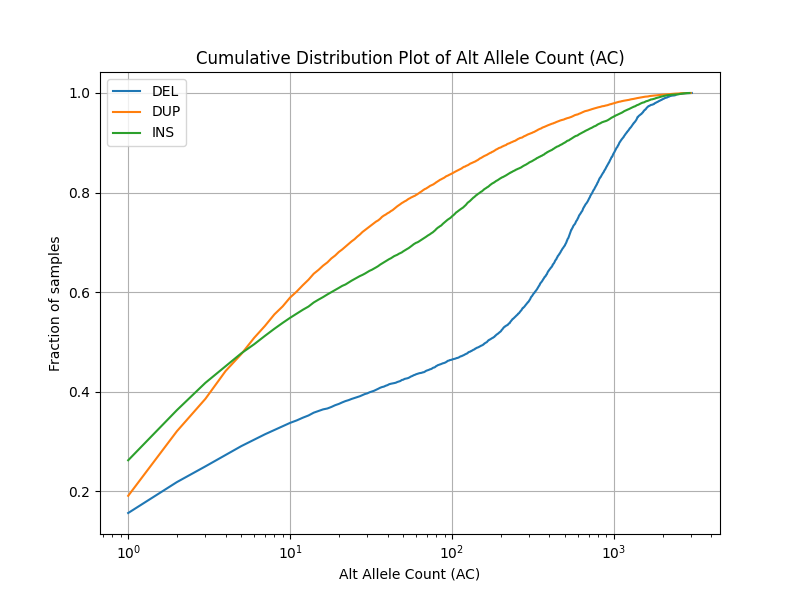

In [13]:
%matplot plt

In [14]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/15x_validation_acdistribution.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
mt2 = mt.annotate_rows(
    AF_class = hl.case()
            .when((mt.variant_qc.AF[1] < 0.001),  "Ultra-rare")
            .when((mt.variant_qc.AF[1] >= 0.001) & (mt.variant_qc.AF[1] < 0.01), "Rare")
            .when((mt.variant_qc.AF[1] >= 0.01), "Common")
            .default("NA") 
)
mt2.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [16]:
df = mt2.select_rows(
    svtype = mt2.callers_info.SVTYPE,
    afclass = mt2.AF_class,
).rows().select('svtype', 'afclass').to_pandas()
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      locus.contig  locus.position  ... svtype     afclass
0             chr1           10546  ...    DEL  Ultra-rare
1             chr1           54720  ...    DUP      Common
2             chr1           66534  ...    DUP  Ultra-rare
3             chr1           83963  ...    DUP        Rare
4             chr1           91449  ...    INS  Ultra-rare
...            ...             ...  ...    ...         ...
40878        chr22        50643837  ...    DUP      Common
40879        chr22        50643858  ...    DUP        Rare
40880        chr22        50643941  ...    DUP        Rare
40881        chr22        50644070  ...    DUP      Common
40882        chr22        50644090  ...    DUP        Rare

[40883 rows x 5 columns]

In [17]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype     afclass
0        DEL  Ultra-rare
1        DUP      Common
2        DUP  Ultra-rare
3        DUP        Rare
4        INS  Ultra-rare
...      ...         ...
40878    DUP      Common
40879    DUP        Rare
40880    DUP        Rare
40881    DUP      Common
40882    DUP        Rare

[40883 rows x 2 columns]

In [18]:
counts_df2= df2.groupby(['svtype', 'afclass']).size().reset_index(name='counts')
counts_df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  svtype     afclass  counts
0    DEL      Common    4161
1    DEL        Rare    1132
2    DEL  Ultra-rare    1482
3    DUP      Common    6652
4    DUP        Rare    6235
5    DUP  Ultra-rare    4149
6    INS      Common    6670
7    INS        Rare    3556
8    INS  Ultra-rare    6846

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()

palette=[  '#980043' , '#df65b0' , '#d4b9da']
#set seaborn plotting aesthetics

sns.set(rc={'figure.figsize':(15,15)})
sns.set(style='whitegrid')

#create grouped bar chart
sns.barplot(x='svtype', y='counts', hue='afclass', data=counts_df2, palette = palette) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='svtype', ylabel='counts'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

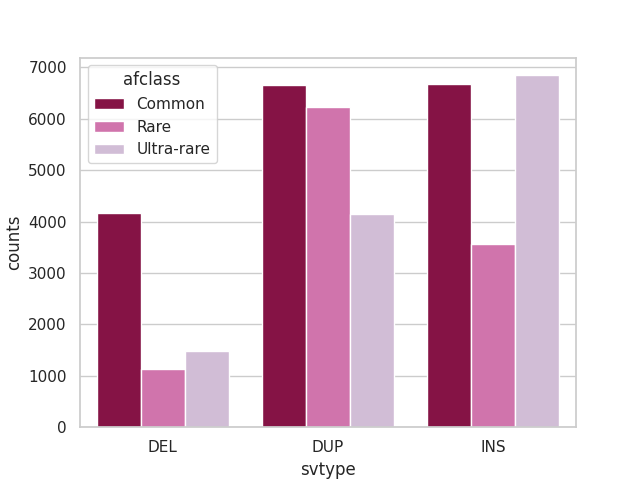

In [20]:
%matplot plt

In [21]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/15xvalidation_AFcounts_byAFclass_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…